Imports

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
from rasterio.plot import show

In [33]:
from PIL import Image
import numpy as np

In [41]:
from shapely.geometry import box

In [39]:
### this is the python package for relative elevation models for rivers
import riverrem

### OSX for open street map overpass
import osmnx as ox


### Bring and plot the tiff file from Open Topography

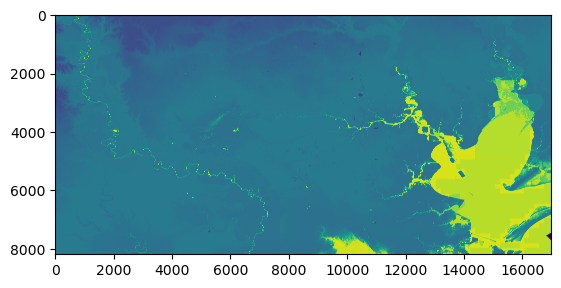

In [5]:
# Load the TIFF
with rasterio.open('../data/output_rem_data/v3/buffaloBayouRegionalV1_USGS10m_hillshade-color.tif') as src:
    img = src.read(1)  # read the first band
    
# Plot the TIFF
fig, ax = plt.subplots(1, 1)
show(img, ax=ax)
plt.show()

## What we need before making a relative elevation model
If give only the DEM to the riverrem package, it finds the largest river in the area
and then uses that as the center line. 

However, we want to focus on Buffalo Bayou. Experience in preceeding notebook has told us that only supplying the centerline of Buffalo bayou leads to weird artifact when a large area is relative to a small bayou, so instead we will use both a center line of Brazos River (big river on left) and Buffalo Bayou which goes through center of tiff above.

### We have polyline shape file of Buffalo Bayou watershed from USGS hydrogeologic database

In [6]:
shapefile = gpd.read_file('../data/rivers_NHD/Shape/NHDFlowline.shp')
print(type(shapefile))
print(shapefile)

<class 'geopandas.geodataframe.GeoDataFrame'>
     permanent_       fdate  resolution   gnis_id              gnis_name  \
0     113253061  2012-01-04           2      None                   None   
1     109566003  2012-01-04           2      None                   None   
2     113254783  2012-01-04           2  01373919           Greens Bayou   
3     113255589  2012-01-04           2      None                   None   
4     113255303  2012-01-04           2      None                   None   
...         ...         ...         ...       ...                    ...   
2877  113251823  2012-01-04           2      None                   None   
2878  113252195  2012-01-04           2      None                   None   
2879  113254411  2012-01-04           2      None                   None   
2880  113253935  2012-01-04           2  01374616  Little Whiteoak Bayou   
2881  113255137  2014-12-05           2      None                   None   

      lengthkm       reachcode  flowdir w

In [7]:
test = shapefile[shapefile['gnis_name']!='Buffalo Bayou 3452']
test['gnis_name'].unique()

array([None, 'Greens Bayou', 'Sims Bayou', 'West Canal', 'Langham Creek',
       'Bear Creek', 'Cotton Patch Bayou', 'Brays Bayou', 'Buffalo Bayou',
       'Garners Bayou', 'Whiteoak Bayou', 'Carpenters Bayou',
       'Willow Fork', 'Spring Branch', 'South Mayde Creek', 'Plum Creek',
       'Snake Creek', 'Little Prong', 'Vince Bayou', 'Briar Branch',
       'Vogel Creek', 'Bering Ditch', 'Mason Creek', 'Berry Bayou',
       'Little Whiteoak Bayou', 'Halls Bayou', 'Rummel Creek',
       'Horsepen Creek', 'Goose Creek', 'Hunting Bayou', 'Patrick Bayou',
       'Keegans Bayou', 'San Jacinto River Authority Canal',
       'San Jacinto River', 'Willow Waterhole Bayou', 'Cole Creek',
       'East Fork Patrick Bayou', 'Cane Island Branch', 'Turkey Creek',
       'Tucker Bayou', 'Country Club Bayou', 'Reinhardt Bayou',
       'Jackson Bayou', 'Dinner Creek', 'Williams Gully', 'Berry Creek',
       'Panther Creek', 'Rolling Fork', 'West Fork Goose Creek',
       'Little Vince Bayou', 'Boggy Ba

In [8]:
### Getting just Buffalo Bayou main channel
geodf_buffaloBayou = shapefile[shapefile['gnis_name']=='Buffalo Bayou']

In [9]:
geodf_buffaloBayou.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [10]:
geodf_buffaloBayou[0:3]

,permanent_,fdate,resolution,gnis_id,gnis_name,lengthkm,reachcode,flowdir,wbarea_per,ftype,fcode,mainpath,innetwork,visibility,SHAPE_Leng,Enabled,ObjectID,geometry
47,113254399,2012-01-04,2,01372802,Buffalo Bayou,0.359,12040104000055,1,None,460,46006,0,1,5000000,0.003579,1,48,"LINESTRING Z (-95.48178 29.77218 0.00000, -95...."
89,113254947,2012-01-04,2,01372802,Buffalo Bayou,0.139,12040104002441,1,120007513,558,55800,0,1,5000000,0.001425,1,90,"LINESTRING Z (-95.11023 29.74014 0.00000, -95...."
136,113254689,2012-01-04,2,01372802,Buffalo Bayou,0.329,12040104000080,1,None,460,46006,0,1,500000,0.003018,1,137,"LINESTRING Z (-95.81983 29.76034 0.00000, -95...."


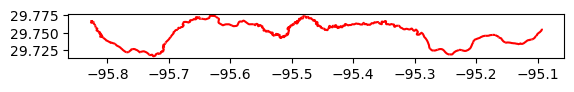

In [12]:
geodf_buffaloBayouWithBuffer = geodf_buffaloBayou.copy()
fig, ax = plt.subplots()
geodf_buffaloBayouWithBuffer.plot(ax=ax, edgecolor="red");

We'll save a reprojected version to new projection?

In [ ]:

# geodf_buffaloBayouWithBuffer.to_file("../data/BuffaloBayouLineFromNHDJoined.shp")


# # Reproject to a projected CRS
# geodf_buffaloBayouWithBuffer_EPSG32615 = geodf_buffaloBayouWithBuffer.to_crs("EPSG:32615")

# # Save the GeoDataFrame as a shapefile
# geodf_buffaloBayouWithBuffer_EPSG32615.to_file("../data/BuffaloBayouLineFromNHDJoined_EPSG32615.shp")

## Now we're get Brazos centerline

In [17]:
# Load the second shapefile and reproject it to EPSG:4326
gdf_nhda = gpd.read_file('../data/output_rem_data/v1/buffaloBayouRegionalV1_USGS10m_river_pts.shp') #python_data_processing/data/rivers_NHD/Shape/NHDWaterbody.shp
gdf_nhda = gdf_nhda.to_crs('EPSG:4326')

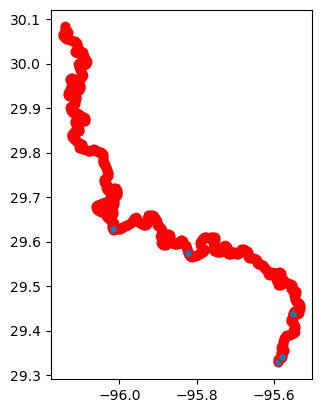

In [18]:
fig, ax = plt.subplots()
gdf_nhda.plot(ax=ax, edgecolor="red"); 

Those are points, not lines, so we'll have to turn them into line

/var/folders/ry/tr7t3nh122z_0n6rz2cl3lv40000gn/T/ipykernel_56232/2194634201.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = gdf_nhda.geometry.distance(gdf_nhda.geometry.shift())


<AxesSubplot:>

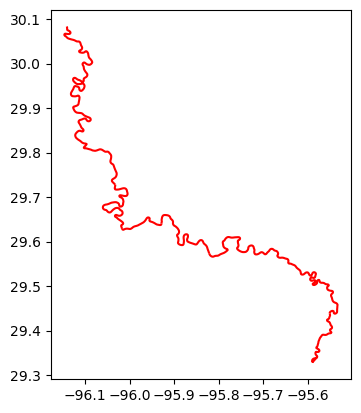

In [20]:
from shapely.geometry import LineString

# # Reproject the data to EPSG:4326
gdf_nhda = gdf_nhda.to_crs(epsg=4326)

# Calculate the distance between consecutive points
distances = gdf_nhda.geometry.distance(gdf_nhda.geometry.shift())

# Set a distance threshold
threshold = 0.04  # replace with your desired threshold

# Create a list to store the points for each LineString
points = []
lines = []

# Iterate over the points and distances
for point, distance in zip(gdf_nhda.geometry, distances):
    # If the distance is less than the threshold, add the point to the current LineString
    if distance <= threshold:
        points.append(point)
    # If the distance is greater than the threshold, start a new LineString
    else:
        # Only add LineStrings with more than one point
        if len(points) > 1:
            lines.append(LineString(points))
        points = [point]

# Add the last LineString if it has more than one point
if len(points) > 1:
    lines.append(LineString(points))

# Create a new GeoDataFrame with the LineStrings
gdf_nhda_lines = gpd.GeoDataFrame(geometry=lines)


# Plot the LineStrings
fig, ax = plt.subplots()
gdf_nhda_lines.plot(ax=ax, edgecolor="red")

In [25]:
# Combine the GeoDataFrames
geodf_buffaloBayou.to_crs(epsg=4326)
combined_gdf = gdf_nhda_lines.append(geodf_buffaloBayou)

# Reproject the data to EPSG:4326
combined_gdf = combined_gdf.set_crs(epsg=4326)

# Save the combined GeoDataFrame as a shapefile
combined_gdf.to_file("../data/reprojected_data/combined_BrazosBuffaloBayou.shp")

/var/folders/ry/tr7t3nh122z_0n6rz2cl3lv40000gn/T/ipykernel_56232/3178526709.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_gdf = gdf_nhda_lines.append(geodf_buffaloBayou)


Now let's confirm Brazos river and Buffalo bayou are in the same thing

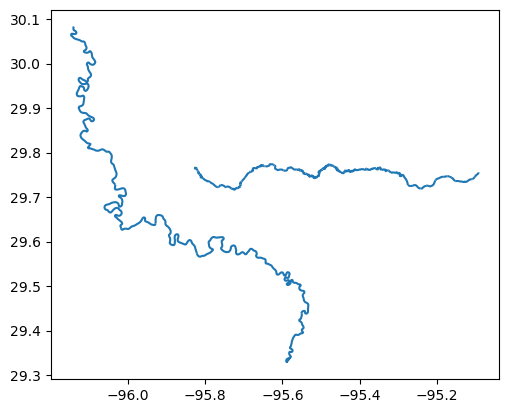

In [26]:
import geopandas as gpd

import matplotlib.pyplot as plt

# Load the shapefile
shapefile_path = "../data/reprojected_data/combined_BrazosBuffaloBayou.shp"
gdf = gpd.read_file(shapefile_path)

# Visualize the shapefile
gdf.plot()
plt.show()

## We also want to overlay faults

In [23]:
# Load the shapefile
gdf = gpd.read_file('../data/faults/texas_faults_fromDor/texas_faults.shp')

# Reproject the CRS to EPSG:4326
gdf_faults  = gdf.to_crs('EPSG:4269')

<AxesSubplot:>

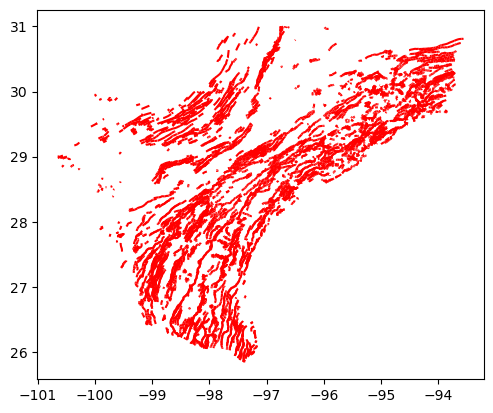

In [24]:
# Visualize the shapefiles
fig, ax = plt.subplots(1, 1)
gdf_faults.plot(ax=ax, color='red')

#### Those faults are from a much larger area, so we'll have to trim them

### Making a relative elevation model relative to the river center lines we have created

In [30]:
from riverrem.REMMaker import REMMaker
# provide the DEM file path and desired output directory
rem_maker = REMMaker(dem='../data/input_rem_data/buffaloBayouRegionalV1_USGS10m.tif', out_dir='../data/output_rem_data/v4/', centerline_shp='../data/reprojected_data/combined_BrazosBuffaloBayou.shp')
# create an REM
rem_maker.make_rem()
# create an REM visualization with the given colormap
rem_maker.make_rem_viz(cmap='mako_r')

[INFO] 2024-05-21 23:14:57,732 - Getting DEM projection.
[INFO] 2024-05-21 23:14:57,734 - Reading DEM as array.
[INFO] 2024-05-21 23:14:59,831 - Getting DEM bounds.
[INFO] 2024-05-21 23:14:59,845 - Mapping array indices to coordinates.
[INFO] 2024-05-21 23:14:59,884 - Using input centerline shapefile.
/Users/justingosses/opt/miniconda3/envs/river-dem/lib/python3.10/site-packages/riverrem/REMMaker.py:322: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.river_length = self.rivers.length.sum()
[INFO] 2024-05-21 23:14:59,945 - Making river points shapefile.
[INFO] 2024-05-21 23:14:59,962 - Getting river elevation at DEM pixels.
[INFO] 2024-05-21 23:15:02,780 - Interpolating river elevation across DEM extent.
[INFO] 2024-05-21 23:15:02,782 - Estimating k.
[INFO] 2024-05-21 23:15:02,803 - Guessing k = 89
[INFO] 2024-05-21 23:15:02,804 - Using k = 89 ne


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache/buffaloBayouRegionalV1_USGS10m_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache/buffaloBayouRegionalV1_USGS10m_REM_color-relief.tif.

Generating .png file.
Saved ./.cache/buffaloBayouRegionalV1_USGS10m_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved ../data/output_rem_data/v4/buffaloBayouRegionalV1_USGS10m_hillshade-color.tif.

Generating .png file.
Saved ../data/output_rem_data/v4/buffaloBayouRegionalV1_USGS10m_hillshade-color.png.


'../data/output_rem_data/v4/buffaloBayouRegionalV1_USGS10m_hillshade-color.tif'

## Looking at the PNG created that is based on the Relative Elevation Model tiff file that was created 

/Users/justingosses/opt/miniconda3/envs/river-dem/lib/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (139123530 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


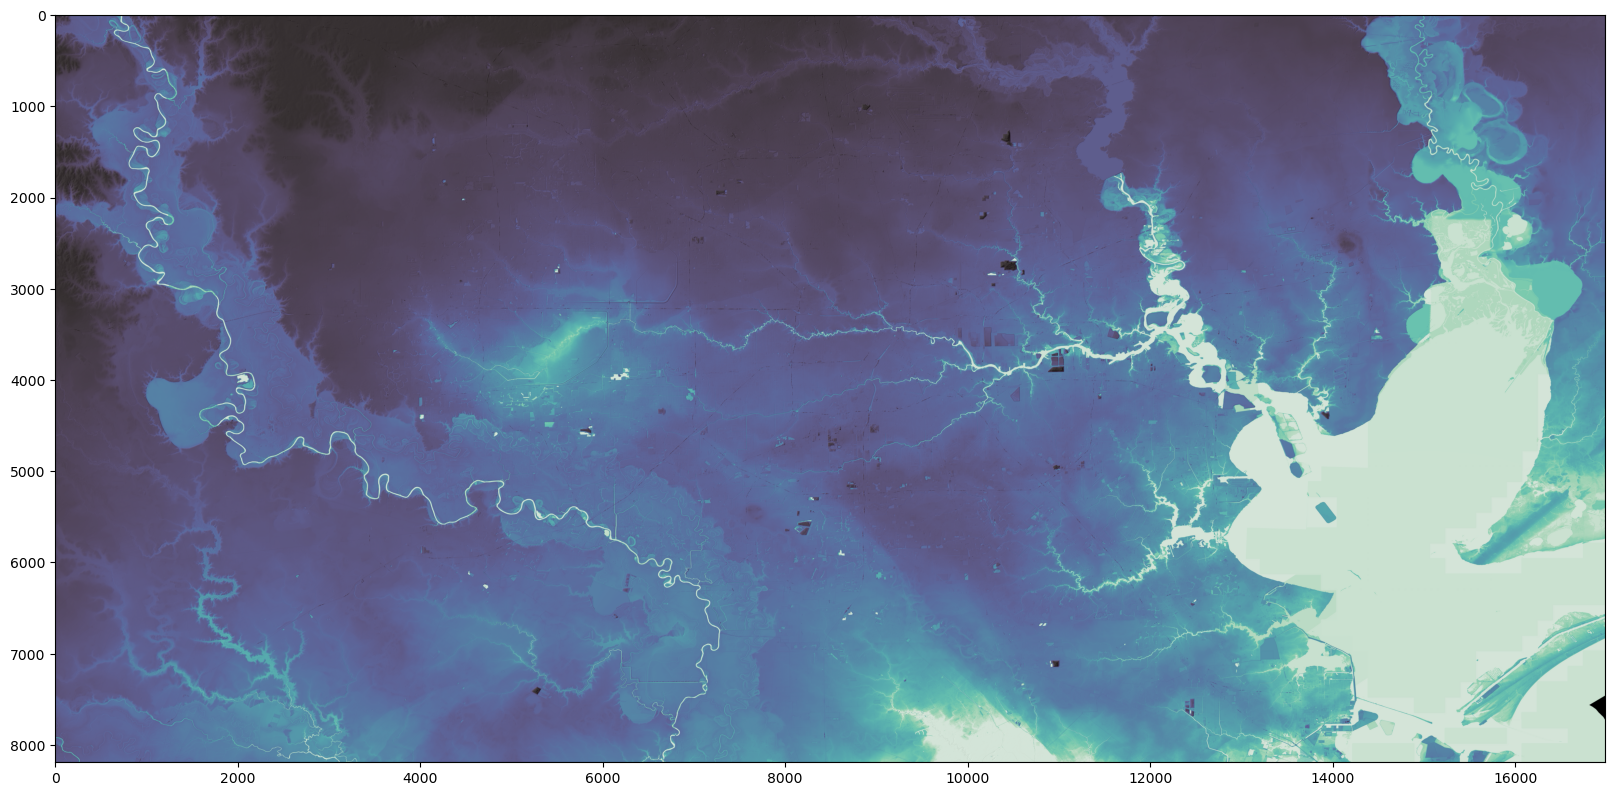

In [34]:
# Load the PNG
img = Image.open('../data/output_rem_data/v4/buffaloBayouRegionalV1_USGS10m_hillshade-color.png')
img_array = np.array(img)

# Plot the PNG
fig, ax = plt.subplots(1, 1, figsize=(20, 20))  # Adjust the size as needed
ax.imshow(img_array)

plt.show()

## Adding Overlays to the tiff that was created in last step

[INFO] 2024-05-21 23:26:48,786 - Failed to auto identify EPSG: 7


got to start of highway part
got different points on bounding box
pounts on building box =  30.083329399808324 29.324996273771987 -94.63444939569881 -96.20731933611141 north, south, east, west 
found points on bounding box
 got G from open street map
turned graph into geodataframe


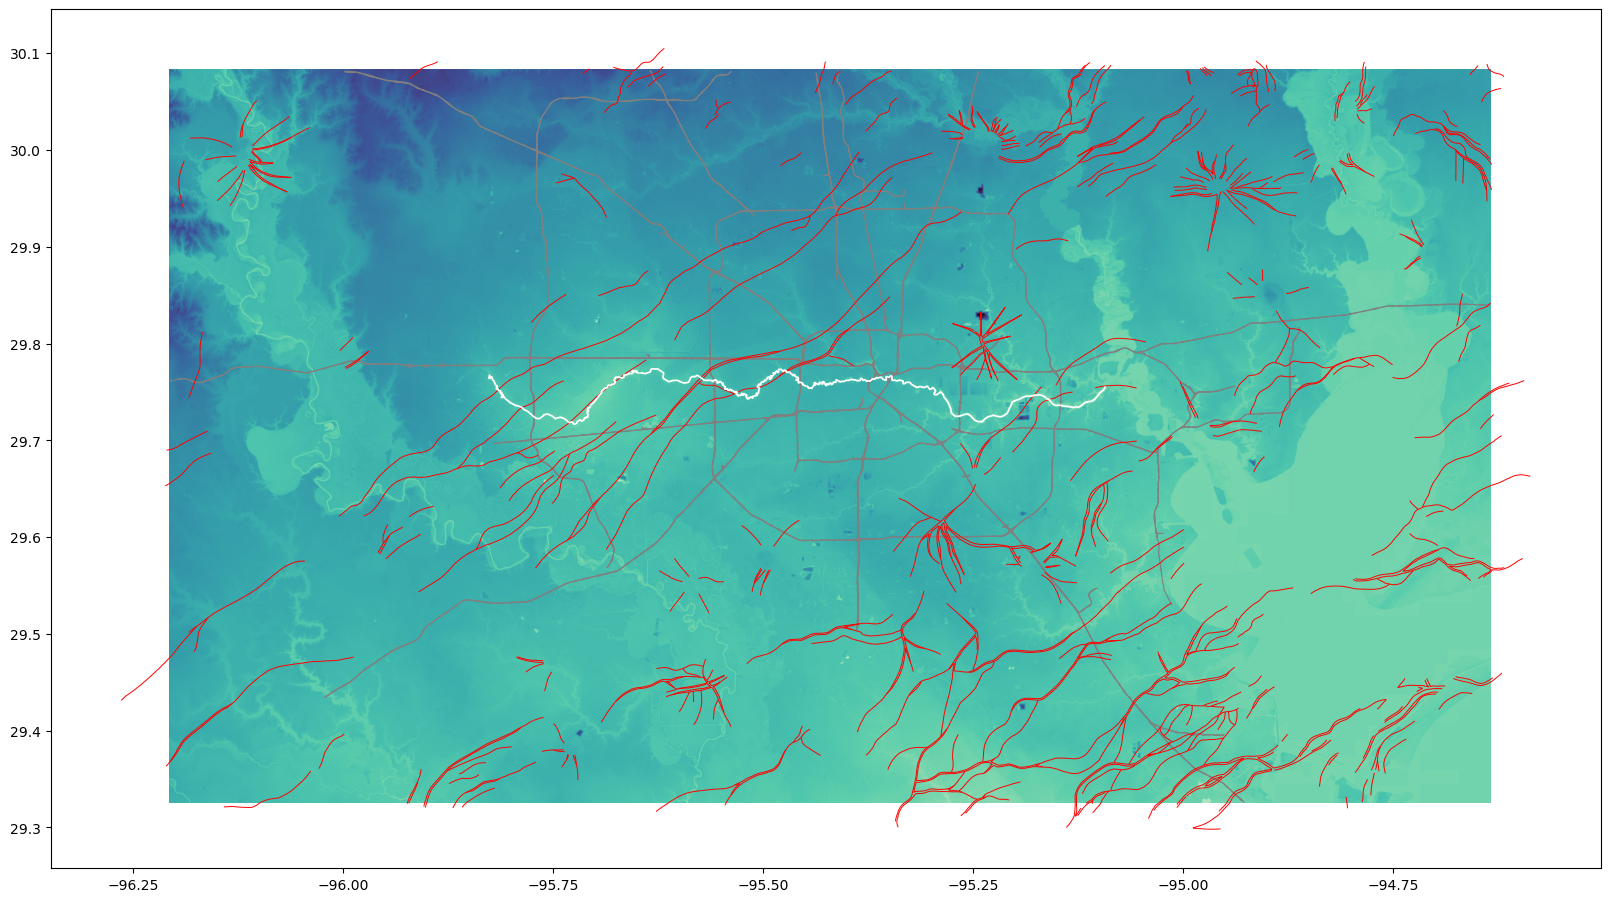

In [42]:
# Load the shapefile and reproject it to EPSG:4326
gdf_faults = gpd.read_file('../data/faults/texas_faults_fromDor/texas_faults.shp')
gdf_faults = gdf_faults.to_crs('EPSG:4326')

# Load the second shapefile and reproject it to EPSG:4326

shapefile = gpd.read_file('../data/rivers_NHD/Shape/NHDFlowline.shp')
shapefile[shapefile['gnis_name']!='Buffalo Bayou 3452']
geodf_buffaloBayou = shapefile[shapefile['gnis_name']=='Buffalo Bayou']
geodf_buffaloBayou.to_crs('EPSG:4326')

# Load the TIFF
with rasterio.open('../data/output_rem_data/v4/buffaloBayouRegionalV1_USGS10m_REM.tif') as src:
    # Calculate the transform and the dimensions for the new CRS
    transform, width, height = calculate_default_transform(src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)

    # Create a new raster for the reprojected TIFF
    with rasterio.open('reprojected.tif', 'w', driver='GTiff', height=height, width=width, count=1, dtype=src.dtypes[0], crs='EPSG:4326', transform=transform) as reprojected:
        # Reproject the TIFF to EPSG:4326
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(reprojected, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs='EPSG:4326',
            resampling=Resampling.nearest)

# Load the reprojected TIFF
with rasterio.open('reprojected.tif') as reprojected:
    img = reprojected.read(1)

    # Clip the reprojected shapefile to the extent of the reprojected TIFF
    gdf_faults = gdf_faults.cx[reprojected.bounds.left:reprojected.bounds.right, reprojected.bounds.bottom:reprojected.bounds.top]
    geodf_buffaloBayou = geodf_buffaloBayou.cx[reprojected.bounds.left:reprojected.bounds.right, reprojected.bounds.bottom:reprojected.bounds.top]


print("got to start of highway part")

# Get the bounds from the reprojected GeoDataFrame
bounds = reprojected.bounds

# Create a bounding box from the bounds
bbox = gpd.GeoDataFrame({'geometry': [box(*bounds)]}, crs=reprojected.crs)
# Reproject the bounding box to WGS84 (the CRS used by OpenStreetMap)
bbox = bbox.to_crs(epsg=4326)

print("got different points on bounding box")

# Get the bounding box coordinates
west, south, east, north = bbox.total_bounds
#-96.20731933611141 29.324996273771987 -94.63444939569881 30.083329399808324 north, south, east, west 

print("pounts on building box = ",north, south, east, west , "north, south, east, west ")
print("found points on bounding box")

# Define the filter
custom_filter = '["highway"~"motorway"]'

# Download the road network
G = ox.graph_from_bbox(north, south, east, west, network_type='drive', custom_filter=custom_filter)

print(" got G from open street map")

# Convert the road network to a GeoDataFrame
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

print("turned graph into geodataframe")

# Plot the reprojected TIFF
fig, ax = plt.subplots(1, 1, figsize=(20, 20))  # Adjust the size as needed
show(img, ax=ax, transform=transform, cmap='mako_r')


# Overlay the road network
edges.plot(ax=ax, color='gray', linewidth=0.8)  # Adjust color and linewidth as needed

# Overlay the reprojected and clipped shapefile
gdf_faults.plot(ax=ax, color='red', edgecolor='red', linewidth=0.7)
geodf_buffaloBayou.plot(ax=ax, color='white', edgecolor='white', linewidth=1.25)

# Save the plot to a PNG file
plt.savefig('../data/output_rem_data/v4/tiffPlusOverlaysPlot_vA.png', dpi=500) 

plt.show()